In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pyarrow.csv as pv
import pyarrow.parquet as pq
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import joblib


In [2]:
df_ml = pd.read_parquet("../Data/data_procesada/Data_business_ml.parquet")
df_ml

,name,state,city,stars,review_count,categories,restaurant_id,sentimiento,sentimiento_escalado
0,San Soo Dang,California,Los Angeles,4.4,18,Korean restaurant,0x80c2c778e3b73d33:0xbdc58662a4a97d49,0.236582,6.182908
1,Vons Chicken,California,La Mirada,4.5,18,Restaurant,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,0.104659,5.523295
2,Oneyda's Bakery,Florida,Naples,4.6,19,"Bakery, Deli",0x88dae191ee505917:0x6ba3e25388d3fad4,0.413616,7.068080
3,La Potranca,California,Los Angeles,4.2,13,Restaurant,0x80c2baf50d29bf63:0x5bd904b842b9fcc,-0.006845,4.965774
4,Raffaello Kosher Pizza,New_York,New York,3.4,8,Restaurant,0x89c258ffaeaba947:0x8355860772a595a9,0.182894,5.914470
...,...,...,...,...,...,...,...,...,...
31756,Sage Mediterranean,Pennsylvania,Phoenixville,4.0,118,Restaurants,150260,0.332883,6.664414
31757,Rustica Restaurant Pizzera,Pennsylvania,New Hope,3.0,21,Pizza,150273,0.118776,5.593881
31758,Ali Baba Magic Food,Pennsylvania,Philadelphia,4.0,8,Restaurants,150287,0.313325,6.566624
31759,Pizza Guru,California,Santa Barbara,4.0,299,Restaurants,150290,0.278261,6.391303


In [3]:
#Limpio las columnas que no utilizare
df_ml_procesado=df_ml.drop(['review_count','name','state'], axis=1)

In [4]:
df_ml_procesado

,city,stars,categories,restaurant_id,sentimiento,sentimiento_escalado
0,Los Angeles,4.4,Korean restaurant,0x80c2c778e3b73d33:0xbdc58662a4a97d49,0.236582,6.182908
1,La Mirada,4.5,Restaurant,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,0.104659,5.523295
2,Naples,4.6,"Bakery, Deli",0x88dae191ee505917:0x6ba3e25388d3fad4,0.413616,7.068080
3,Los Angeles,4.2,Restaurant,0x80c2baf50d29bf63:0x5bd904b842b9fcc,-0.006845,4.965774
4,New York,3.4,Restaurant,0x89c258ffaeaba947:0x8355860772a595a9,0.182894,5.914470
...,...,...,...,...,...,...
31756,Phoenixville,4.0,Restaurants,150260,0.332883,6.664414
31757,New Hope,3.0,Pizza,150273,0.118776,5.593881
31758,Philadelphia,4.0,Restaurants,150287,0.313325,6.566624
31759,Santa Barbara,4.0,Restaurants,150290,0.278261,6.391303


In [5]:
#creo un data frame para comparar al final
df_comparacion = df_ml_procesado.copy()

In [6]:
#codifico los valores que tienen object para el analisis ML
label_encoder = LabelEncoder()

for columna in df_comparacion.columns:
    if df_comparacion[columna].dtype == 'object':
        df_comparacion[columna] = label_encoder.fit_transform(df_comparacion[columna])

In [7]:
df_comparacion

,city,stars,categories,restaurant_id,sentimiento,sentimiento_escalado
0,1329,4.4,1771,4138,0.236582,6.182908
1,1176,4.5,2396,7145,0.104659,5.523295
2,1586,4.6,268,10567,0.413616,7.068080
3,1329,4.2,2396,3722,-0.006845,4.965774
4,1633,3.4,2396,12879,0.182894,5.914470
...,...,...,...,...,...,...
31756,1857,4.0,2768,25979,0.332883,6.664414
31757,1614,3.0,2234,25980,0.118776,5.593881
31758,1850,4.0,2768,25981,0.313325,6.566624
31759,2116,4.0,2768,25982,0.278261,6.391303


Verifico que no se hayan duplicado los valores de restaurant_id

In [8]:
# Contar los valores en la columna 'restaurant_id'
value_counts = df_comparacion['restaurant_id'].value_counts()

# Filtrar los valores que aparecen más de una vez
duplicates = value_counts[value_counts > 1]


Realizo un analisis de los datos que voy a usar para el modelo

C:\Users\Manuel\AppData\Local\Temp\ipykernel_56292\383715221.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city', y='stars', data=avg_stars_by_state, palette='viridis')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

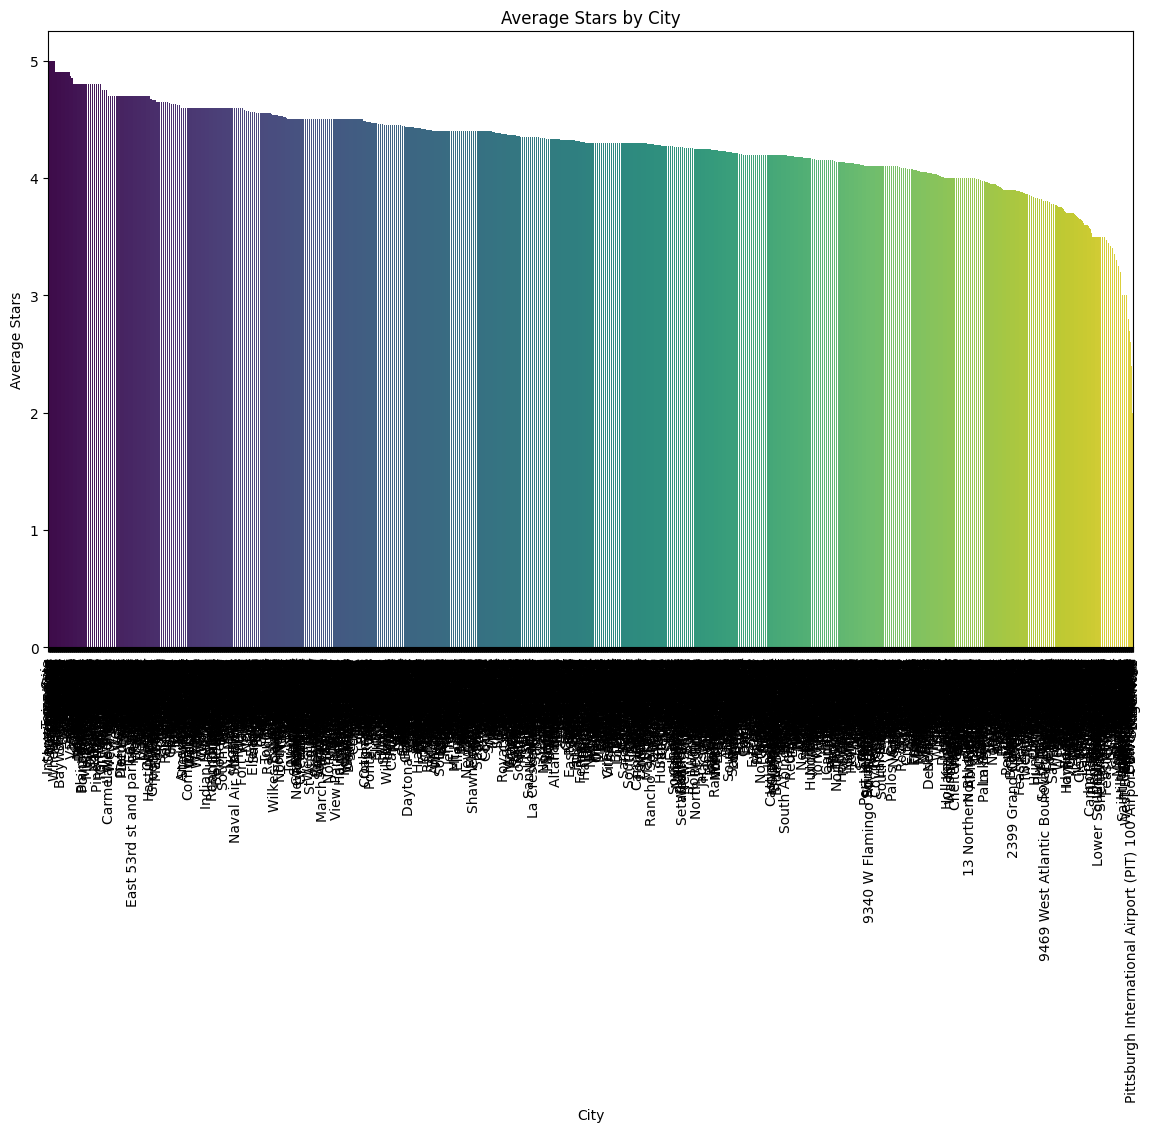

In [10]:
# Agrupar por 'state' y calcular el promedio de 'stars'
avg_stars_by_state = df_ml_procesado.groupby('city')['stars'].mean().reset_index()

# Ordenar los resultados por el promedio de estrellas
avg_stars_by_state = avg_stars_by_state.sort_values(by='stars', ascending=False)

# Configuración del tamaño del gráfico
plt.figure(figsize=(14, 8))

# Crear el gráfico de barras
sns.barplot(x='city', y='stars', data=avg_stars_by_state, palette='viridis')

# Añadir etiquetas y título
plt.xlabel('City')
plt.ylabel('Average Stars')
plt.title('Average Stars by City')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje X si hay muchos estados

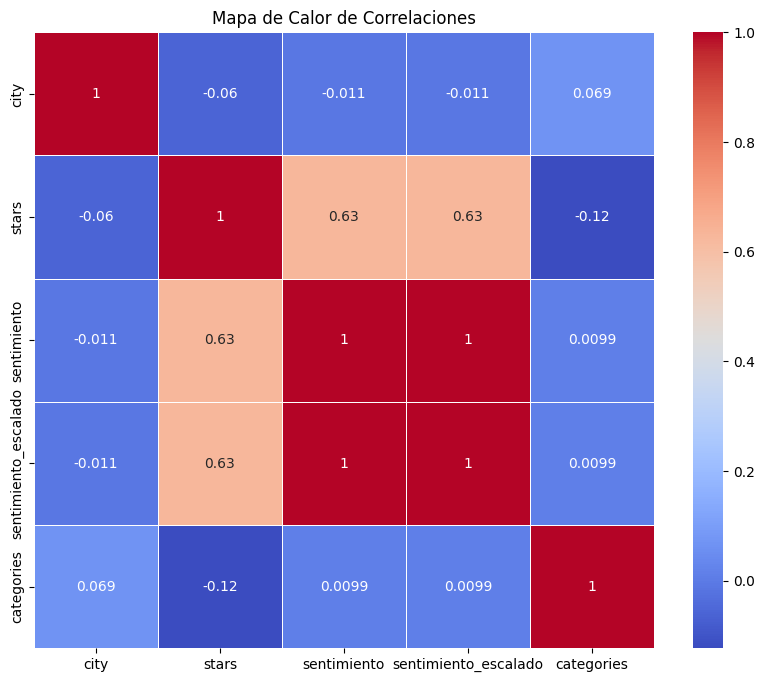

In [12]:
#Analizo las variables representativas
variables = df_comparacion[['city', 'stars', 'sentimiento', 'sentimiento_escalado', 'categories']]


correlation_matrix = variables.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones')
plt.show()

MODELO


Para este caso se utilizo un modelo de Sklearn, RandomForestClasificador, para poder aplicar un modelo de arboles de desicion. 

In [13]:
df_ml_procesado

,city,stars,categories,restaurant_id,sentimiento,sentimiento_escalado
0,Los Angeles,4.4,Korean restaurant,0x80c2c778e3b73d33:0xbdc58662a4a97d49,0.236582,6.182908
1,La Mirada,4.5,Restaurant,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,0.104659,5.523295
2,Naples,4.6,"Bakery, Deli",0x88dae191ee505917:0x6ba3e25388d3fad4,0.413616,7.068080
3,Los Angeles,4.2,Restaurant,0x80c2baf50d29bf63:0x5bd904b842b9fcc,-0.006845,4.965774
4,New York,3.4,Restaurant,0x89c258ffaeaba947:0x8355860772a595a9,0.182894,5.914470
...,...,...,...,...,...,...
31756,Phoenixville,4.0,Restaurants,150260,0.332883,6.664414
31757,New Hope,3.0,Pizza,150273,0.118776,5.593881
31758,Philadelphia,4.0,Restaurants,150287,0.313325,6.566624
31759,Santa Barbara,4.0,Restaurants,150290,0.278261,6.391303


In [14]:
df_ml_procesado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31761 entries, 0 to 31760
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  31761 non-null  object 
 1   stars                 31761 non-null  float64
 2   categories            31761 non-null  object 
 3   restaurant_id         31761 non-null  object 
 4   sentimiento           31761 non-null  float64
 5   sentimiento_escalado  31761 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.5+ MB


#Elijo las 10 categorias con mas restaurantes para reducir la variabilidad de categorias y mejorar la presicion del modelo


In [15]:
top_10_categories = df_ml_procesado['categories'].value_counts().nlargest(10).index
top_10_categories

Index(['Restaurants', 'Restaurant', 'Food', 'Mexican restaurant',
       'Pizza restaurant', 'Chinese restaurant', 'Cafe', 'Bakery', 'Pizza',
       'American restaurant'],
      dtype='object', name='categories')

In [16]:
#Tomo una muestra de los datos
df_muestra = df_ml_procesado.sample(frac=1, random_state=42)

In [17]:
df_muestra

,city,stars,categories,restaurant_id,sentimiento,sentimiento_escalado
15095,Bronx,4.5,Soul food restaurant,0x89c2f3d564a31ecf:0xae7a7c649dd68926,0.366910,6.834550
13212,Doral,4.1,Cuban restaurant,0x88d9bbc546c18f33:0xd7b15542917e4cd,0.335166,6.675828
24387,Philadelphia,4.0,Fast Food,19605,0.236072,6.180360
14145,Grover Beach,4.4,"Persian restaurant, Mediterranean restaurant, ...",0x80ec5fc233e337c7:0x8a581039d4f2fa6e,0.347915,6.739577
5005,Mariposa,4.8,Restaurant,0x8096bbacff7658f5:0x38dfccce56f212a4,0.506765,7.533827
...,...,...,...,...,...,...
29802,Tampa,3.5,Restaurants,112036,0.248342,6.241708
5390,Poughkeepsie,4.2,Seafood restaurant,0x89dd3fad9eeaa955:0x50dd2c4fa50abec4,0.205976,6.029881
860,New York,3.7,Thai restaurant,0x89c259810f06cbc7:0xc0e7257ea1d7c98a,0.179952,5.899761
15795,Las Vegas,3.7,"Seafood restaurant, Mexican restaurant",0x80c8c36120a204f7:0x7b4a433f5812a9f4,0.244479,6.222395


In [18]:
# Definir las categorías de interés
categories_of_interest = ['Restaurants', 'Restaurant', 'Food', 'Mexican restaurant', 'Pizza restaurant', 'Chinese restaurant', 'Cafe', 'Bakery', 'Pizza', 'American restaurant']

# Filtrar el dataframe para que solo contenga las filas con las categorías de interés
df_filtered = df_muestra[df_muestra['categories'].isin(categories_of_interest)]

In [19]:
df_filtered

,city,stars,categories,restaurant_id,sentimiento,sentimiento_escalado
5005,Mariposa,4.8,Restaurant,0x8096bbacff7658f5:0x38dfccce56f212a4,0.506765,7.533827
3510,Walden,4.3,Chinese restaurant,0x89dd29b0eabad8a7:0x845c2f5f6fe022b8,0.227312,6.136562
26831,Tampa,4.5,Food,59491,0.336212,6.681058
26990,Philadelphia,2.0,Restaurants,62315,-0.110941,4.445295
24308,Pottstown,4.5,Restaurants,18482,0.332566,6.662831
...,...,...,...,...,...,...
6265,East Los Angeles,3.8,Pizza restaurant,0x80c2ce348b3c8e0b:0xf98fdf5195b209b0,0.314615,6.573077
11284,Buffalo,4.4,Pizza restaurant,0x89d3091e3aa64fbd:0x976262088fb25075,0.366149,6.830743
21575,Richland,4.5,Pizza restaurant,0x89c60fa7c2e5772d:0x629d78e503876ed0,0.332650,6.663250
29802,Tampa,3.5,Restaurants,112036,0.248342,6.241708


In [20]:
# Preparar los datos
X = df_filtered[['city', 'stars', 'sentimiento', 'sentimiento_escalado']]
y = df_filtered['categories']

# Codificar variables categóricas
X = pd.get_dummies(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)



Precisión del modelo: 0.40995732574679944


Dado que la presicion del modelo es relativamente baja, se opto por mejorar esta mediante un metodo para reducir las combinaciones de los hiperparametros

In [21]:
# Exploración de correlaciones
print(df_comparacion.corr())

                          city     stars  categories  restaurant_id  \
city                  1.000000 -0.060116    0.069337       0.104200   
stars                -0.060116  1.000000   -0.122936      -0.296748   
categories            0.069337 -0.122936    1.000000       0.198640   
restaurant_id         0.104200 -0.296748    0.198640       1.000000   
sentimiento          -0.011055  0.627520    0.009903      -0.050333   
sentimiento_escalado -0.011055  0.627520    0.009903      -0.050333   

                      sentimiento  sentimiento_escalado  
city                    -0.011055             -0.011055  
stars                    0.627520              0.627520  
categories               0.009903              0.009903  
restaurant_id           -0.050333             -0.050333  
sentimiento              1.000000              1.000000  
sentimiento_escalado     1.000000              1.000000  


Reducir el Número de Combinaciones de Hiperparámetros 

Limita el número de combinaciones de hiperparámetros para hacer la búsqueda más manejable. Puedes empezar con un conjunto más pequeño de valores para cada hiperparámetro.

In [23]:
# Seleccionar las características y la variable objetivo
X = df_filtered[['city', 'stars', 'sentimiento', 'sentimiento_escalado']]
y = df_filtered['categories']

# Codificar variables categóricas
X = pd.get_dummies(X)

# Ver la distribución de las clases
print(y.value_counts())

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste del modelo con GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Hacer predicciones
y_pred = best_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Validación cruzada
cv_scores = cross_val_score(best_model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", cv_scores.mean())

categories
Restaurants            4871
Restaurant             4038
Food                   1956
Mexican restaurant     1243
Pizza restaurant       1107
Chinese restaurant     1105
Cafe                   1022
Bakery                  987
Pizza                   693
American restaurant     553
Name: count, dtype: int64
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Precisión del modelo: 0.47624466571834995
[[  0   1   0   1   1   0   0   1 103  11]
 [  0   3   3   3   1   1   0   0 172  17]
 [  0   4   3   7   4   0   0   0 166  26]
 [  0   1   5  24   0   0   0   1 147  30]
 [  0   0   0   2  36   0   0   0  14 364]
 [  0   1   1   8   0   2   0   0 183  25]
 [  0   0   0   0   0   0   0   0   4 114]
 [  0   0   1   6   1   2   0   0 186  35]
 [  0   5   3  13   4   2   0   2 649  84]
 [  0   0   0   1  54   0   0   0  20 957]]
                     precision    recall  f1-score   support

American restaurant       0.00      0.00      0.00       118
             Bakery      

c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Cross-validation scores: [0.47368421 0.47368421 0.46571835 0.47311522 0.47311522]
Average cross-validation score: 0.4718634423897582


In [24]:
# Hacer predicciones para un estado específico (por ejemplo, 'California' y 4 estrellas)
# Generar el conjunto de datos de entrada para la predicción
state = 'New_York'
stars = 4
sentimiento = 0.1  # Solo un valor de ejemplo, debes ajustarlo según tu criterio
sentimiento_escalado = 3.0  # Solo un valor de ejemplo, debes ajustarlo según tu criterio

# Crear un DataFrame con las características del restaurante
input_data = pd.DataFrame({
    'state': [state],
    'stars': [stars],
    'sentimiento': [sentimiento],
    'sentimiento_escalado': [sentimiento_escalado]
})

# Aplicar codificación one-hot para el estado
input_data = pd.get_dummies(input_data)

# Asegurarse de que todas las columnas de estado estén presentes en el conjunto de datos de entrada
# Si falta alguna columna de estado, agregarla con valor 0
missing_cols = set(X_train.columns) - set(input_data.columns)
for col in missing_cols:
    input_data[col] = 0

# Reordenar las columnas para que coincidan con el orden del conjunto de entrenamiento
input_data = input_data[X_train.columns]

# Realizar la predicción
predicted_category = best_model.predict(input_data)

print("La categoría recomendada para abrir un restaurante con 4.5 o más estrellas en New_York es:", predicted_category[0])

C:\Users\Manuel\AppData\Local\Temp\ipykernel_56292\2745466054.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_data[col] = 0
C:\Users\Manuel\AppData\Local\Temp\ipykernel_56292\2745466054.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_data[col] = 0
C:\Users\Manuel\AppData\Local\Temp\ipykernel_56292\2745466054.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

La categoría recomendada para abrir un restaurante con 4.5 o más estrellas en New_York es: Restaurant


C:\Users\Manuel\AppData\Local\Temp\ipykernel_56292\2745466054.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_data[col] = 0
C:\Users\Manuel\AppData\Local\Temp\ipykernel_56292\2745466054.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_data[col] = 0
C:\Users\Manuel\AppData\Local\Temp\ipykernel_56292\2745466054.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [25]:
joblib.dump(best_model, 'modelo_entrenado_city.pkl')
joblib.dump(X_train.columns, 'columnas_entrenamiento_city.pkl')


['columnas_entrenamiento_city.pkl']